In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp


In [2]:
with open('lists.json') as f:
    j = json.load(f)

target_list = j['target']
guess_list = j["guess"]


In [3]:
def char_freq(lst):
    hist = defaultdict(int)
    for word in lst:
        for char in word:
            hist[char] += 1
    mx = max(hist.values())
    for char in hist:
        hist[char] /= mx
    return hist

def print_char_freq(cf):
    for char in sorted(list(cf.keys())):
        print(f'{char}: {cf[char]}')
        
def freq_score(word, cf):
    return sum(cf[x] for x in word) / len(word) 

def uniq_score(word):
    return (len(word) - len(set(word))) / (len(word) - 2)

In [4]:

cf = char_freq(target_list)
#print_char_freq(cf)

In [5]:
print(random.choice(guess_list))
print(random.choice(target_list))

scapa
dread


In [6]:
dfg = pd.DataFrame([[w, freq_score(w, cf), uniq_score(w), 1] for w in guess_list], columns=['word', 'freq_score', 'uniq_score', 'is_guess_word'])
dft = pd.DataFrame([[w, freq_score(w, cf), uniq_score(w), 0] for w in target_list], columns=['word', 'freq_score', 'uniq_score', 'is_guess_word'])
df = dfg.append(dft)
df.set_index('word', inplace=True)

In [7]:
df.iloc[2801]

freq_score       0.725547
uniq_score       1.000000
is_guess_word    1.000000
Name: esses, dtype: float64

In [8]:


def word_to_action(word, guesses, history):
    return dfword_to_action((word, df.loc[word]), guesses, history)
    
def dfword_to_action(dfword, guesses, history):
    #the action is going to be a word that we will submit next
    #for the purposes of feeding into the model, we will represent the action word as:
    #  how many of the entries in the hint history this word conforms to
    #  how many untried letters it gives us
    #  the number of uniq letters in the word
    #  the frequency of the letters in the word
    #  whether or not the word is in the guess list (as opposed to the target list)
    word = dfword[0]
    dfword = dfword[1]
    if guesses:
        conforms_to_history = sum([int(validate_against_hint(word,g,history[i])) for i,g in enumerate(guesses)]) / len(guesses)
    else: # we haven't made any guess yet, so this must conform
        conforms_to_history = 1.0
    num_untried_letters = len(set(word) - set(''.join(guesses))) / 5 #normalise to 1
    return np.array([conforms_to_history, num_untried_letters, dfword['freq_score'], dfword['uniq_score'], dfword['is_guess_word']])
    

In [9]:
df_global = None

def construct_actions_global(arg): #guesses, history, start_idx, end_idx):
    #global df_global
    guesses, history, start_idx, end_idx = arg
    #print(guesses, history, start_idx, end_idx)
    return np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iloc[start_idx:end_idx].iterrows()])
    
class ActionSpace:
    def __init__(self, n):
        self.n = n
    
    
class Env:
    def __init__(self, df, target_word=None):
        self.df = df
        self.specified_target_word = False
        if target_word:
            self.specified_target_word = True
            self.target = target_word            
            
        self.reset()     
        self.num_letters = len(self.target)
        self.num_guesses = 6
        
        self.num_processes = mp.cpu_count() - 1
        self.action_space = ActionSpace(len(self.df))
       
    
    def word_from_index(self, idx):
        return self.df.iloc[idx].name
    
    def submit_guess(self, guess):
        wrongplace = [0] * len(self.target)
        hints = np.zeros(len(self.target))
        rightplace = [guess[n] == chrt for n,chrt in enumerate(self.target)]
        #print(f'comparing {guess} against {self.target}.  rightplace {rightplace}')
        
        for n,chrt in enumerate(self.target):
            if rightplace[n] == 1: continue #this character has already been scored, skip it
            for m,chrg in enumerate(guess):
                if n == m: continue # we've already checked rightplace matches above
                if chrt != chrg: continue
                if wrongplace[m] == 1: continue
                if rightplace[m] == 1: continue
                
                wrongplace[m] = 1
                break

        for i in range(len(self.target)):
            hints[i] = 2 if rightplace[i] == 1 else wrongplace[i]
        
        return hints
    
    def reset(self):
        self.history = np.array([[]])
        self.guesses = []
        if not self.specified_target_word:
            self.target = df[df['is_guess_word'] == 0.0].sample().iloc[0].name
            
    def construct_actions(self):
        return np.array([dfword_to_action(dfword, self.guesses, self.history) for dfword in self.df.iterrows()])
    
    def construct_actions_mp(self):
        #global df_global
        
        grp_lst_args = []
        grp_guesses = [self.guesses] * self.num_processes
        grp_history = [self.history] * self.num_processes
        
        #df_global = self.df
        chunk_size = int(len(self.df) / self.num_processes) + 1
        start_offsets = list(range(0, len(self.df), chunk_size))
        end_offsets = start_offsets[1:] + [len(self.df)]
        grp_lst_args = list(zip(grp_guesses, grp_history, start_offsets, end_offsets))
        
        #print(grp_lst_args)
        self.pool = mp.Pool(processes=self.num_processes)
        results = self.pool.map(construct_actions_global, grp_lst_args)
        self.pool.close()
        self.pool.join()
        return np.concatenate(results)
    
    def construct_state(self):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(self.history.max(axis=0) == 2)

        green_chars = [self.guesses[x][y] for x,y in np.argwhere(self.history == 2) ]
        orange_chars = [self.guesses[x][y] for x,y in np.argwhere(self.history == 1) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))

        sequence_number = self.history.shape[0]

        return np.array([num_green_locs, num_other_letters, sequence_number]) / 5

    def step_by_index(self, guess_idx):
        return self.step(self.word_from_index(guess_idx))
    
    
    def step(self, guess): #returns state, reward, done, actions
        #print(actions)
        hints = self.submit_guess(guess)

        #print(list(zip(self.guesses,self.history)))
        if self.history.size == 0:
            self.history = np.expand_dims(hints,0)
            best_hints = 0
        else:
            best_hints = np.apply_along_axis(np.sum, 1, self.history).max()
            self.history = np.row_stack([self.history, hints])
            
        print(f'======={guess} ({self.target}) => {hints}= {best_hints} =======')
        
        self.guesses.append(guess)
        reward = max(0, hints.sum() - best_hints)
        done = (hints.sum() == self.num_letters * 2 or len(self.guesses) == self.num_guesses)
    
        state = self.construct_state() 
        actions = self.construct_actions_mp()
        return state, reward, done, actions

    
def hint_to_hinty(hint):
    #hint takes form [0,1,2,1,0]
    #hinty takes form {2:[2], 1:[1,3], 0:[0,4]}
    hinty = {}
    for n in [0,1,2]:
        hinty[n] = [i for i, x in enumerate(hint) if x == n]
    #print(f'hint_to_hinty() {hint}, {hinty}')
    return hinty
    
def validate_against_hint(word, guess, hint):
    return validate_against_hinty(word, guess, hint_to_hinty(hint))

def validate_against_hinty(word, guess, hinty):
    #hinty takes form {2:[idx,..], 1:[idx,..], 0:[idx,..]}
    for idx in hinty[2]: # check the fixed letters first
        if word[idx] != guess[idx]:
            return False
    for idx in hinty[0]:
        #get the number of times char appears in target word (minus the times it appears in the correct location)
        indices = [i for i,x in enumerate(word) if x == guess[idx] and i not in hinty[2]]
        #get number of times char appears in guess word in the wrong location
        indices_g = [n for n,x in enumerate(guess) if x == guess[idx] and n in hinty[1]]
        #we already know that there is one not-exist hint for this char, so
        #if there are more fewer wrong location hints for this letter than there are actual occurrences of the letter
        #then the hint does not validate against this word
        if len(indices) > len(indices_g):
            return False
    for idx in hinty[1]:
        if word[idx] == guess[idx]:
            return False
        #get all the indices of the character in the target word
        indices = [i for i,x in enumerate(word) if x == guess[idx] and i not in hinty[2]]
        #remove all the indices where there is already a fixed position hint
        
        #now count all the occurences of the char in guess where the location is wrong
        indices_g = [i for i,x in enumerate(guess) if x == guess[idx] and i in hinty[1]]
        #if there are more wrong loc hints for this char than there are actual occurrences, then it must be bogus
        if len(indices) < len(indices_g):
            return False
    return True            
    

In [10]:
e = Env(df)
e.reset()
st = time.time()
rmp = e.construct_actions_mp()
print(time.time() - st)
e.reset()
st = time.time()
r = e.construct_actions()
print(time.time() - st)

print(r.__class__)
print(r.shape)

print(rmp.__class__)
print(rmp.shape)

print((r == rmp).all())


0.3304414749145508
0.7097568511962891
<class 'numpy.ndarray'>
(12972, 5)
<class 'numpy.ndarray'>
(12972, 5)
True


In [11]:
e_simple = Env(target_list, target_word='abcde')
tests_simple = {'abcde': [2,2,2,2,2],
         'acbde': [2,1,1,2,2],
         'azcde': [2,0,2,2,2],
         'aacde': [2,0,2,2,2],
         'zacde': [0,1,2,2,2],
         'zzdzz': [0,0,1,0,0],
         'zzddz': [0,0,0,2,0],
         'zdddz': [0,0,0,2,0],
         'ddddd': [0,0,0,2,0],
         'zzzdd': [0,0,0,2,0],
         'zzdez': [0,0,1,1,0]}

e_repeat = Env(target_list, target_word='abcae')
tests_repeat = {'abcde': [2,2,2,0,2],
         'acbde': [2,1,1,0,2],
         'azcde': [2,0,2,0,2],
         'aacde': [2,1,2,0,2],
         'zacde': [0,1,2,0,2],
         'zzdzz': [0,0,0,0,0],
         'zzddz': [0,0,0,0,0],
         'zdddz': [0,0,0,0,0],
         'ddddd': [0,0,0,0,0],
         'zzzdd': [0,0,0,0,0],
         'zzdez': [0,0,0,1,0],
         'aaaaa': [2,0,0,2,0],
         'aaaza': [2,1,0,0,0],
         'zaazz': [0,1,1,0,0],
         'zaaza': [0,1,1,0,0]}

for e,tests in [(e_simple, tests_simple),(e_repeat, tests_repeat)]:
    for guess,expected in tests.items():
        #guess = random.choice(guess_list + target_list)
        actual = e.submit_guess(guess)
        hinty = hint_to_hinty(expected)
        hinty_valid = validate_against_hinty(e.target, guess, hinty)
        print(e.target, guess, actual, expected, expected == actual, hinty_valid)

comparing abcde against abcde.  rightplace [True, True, True, True, True]
abcde abcde [2. 2. 2. 2. 2.] [2, 2, 2, 2, 2] [ True  True  True  True  True] True
comparing acbde against abcde.  rightplace [True, False, False, True, True]
abcde acbde [2. 1. 1. 2. 2.] [2, 1, 1, 2, 2] [ True  True  True  True  True] True
comparing azcde against abcde.  rightplace [True, False, True, True, True]
abcde azcde [2. 0. 2. 2. 2.] [2, 0, 2, 2, 2] [ True  True  True  True  True] True
comparing aacde against abcde.  rightplace [True, False, True, True, True]
abcde aacde [2. 0. 2. 2. 2.] [2, 0, 2, 2, 2] [ True  True  True  True  True] True
comparing zacde against abcde.  rightplace [False, False, True, True, True]
abcde zacde [0. 1. 2. 2. 2.] [0, 1, 2, 2, 2] [ True  True  True  True  True] True
comparing zzdzz against abcde.  rightplace [False, False, False, False, False]
abcde zzdzz [0. 0. 1. 0. 0.] [0, 0, 1, 0, 0] [ True  True  True  True  True] True
comparing zzddz against abcde.  rightplace [False, Fa

In [12]:
def random_guess(guess_list, target_list):
    guess_idx = random.randint(0, len(guess_list) + len(target_list))
    is_guess = guess_idx < len(guess_list)
    if is_guess:
        word = guess_list[guess_idx]
    else:
        word = target_list[guess_idx - len(guess_list)]
    return word, is_guess

In [13]:
#'beast'
e = Env(df, target_word='beast')
e.step('treat')
#e.guesses = ['treat']
#e.history = np.array([[0.0, 0.0, 1.0, 1.0, 2.0]])
#Env(target_list, target_word='beast').submit_guess('treat')
print(e.guesses, e.history)
actual = e.construct_state()
expected = [0.2, 0.4, 0.2]
print(expected, actual, expected == actual)

actual = word_to_action('feast', ['treat'], np.array([[0.0, 0.0, 1.0, 1.0, 2.0]]))
expected = [1.0, 0.4, 0.62287105, 0.0, 0.0]
print(expected, actual, expected == actual)


comparing treat against beast.  rightplace [False, False, False, False, True]
=======treat (beast) => [0. 0. 1. 1. 2.]= 0 =======
['treat'] [[0. 0. 1. 1. 2.]]
[0.2, 0.4, 0.2] [0.2 0.4 0.2] [ True  True  True]
[1.0, 0.4, 0.62287105, 0.0, 0.0] [1.         0.4        0.62287105 0.         0.        ] [ True  True False  True  True]


In [14]:
num_guesses = 6
e = Env(df)

print(e.target)
num_letters = len(e.target)
history = np.array([[]])
guesses = []
rewards = []
for i in range(num_guesses):
    #guess, is_guess_list = random_guess(guess_list, target_list)
    actions = e.construct_actions_mp()
    state = e.construct_state()
    #here feed it into a model to choose the word
    #guess, value = np.argmax(model(state)) # but do this epsilon greedy
    
    #print(actions)
    hints = e.submit_guess(guess)
    
    print(f'======={guess}========')
    print(list(zip(guesses,history)))
    if history.size == 0:
        history = np.expand_dims(hints,0)
    else:
        history = np.row_stack([history, hints])
    guesses.append(guess)
    if hints.sum() == num_letters * 2 or i == num_guesses - 1:
        reward = hints.sum()
        done = True
    else:
        reward = -1
        done = False
    
    

    
#so the state is going to be:
#  The number of green locations we know
#  The number of other letters we know to be in the word
#  The sequence number of the guess (1st guess, 2nd guess etc.)

#the action is going to be a word that we will submit next
#for the purposes of feeding into the model, we will represent the action word as:
#  whether or not it conforms to the hint history
#  how many new letters it gives us
#  the number of uniq letters in the word
#  the frequency of the letters in the word

#the reward is going to be:
#  -1 on all states except the last one
#  on the last state (which can either be after guess 6 or on guessing the correct word):
#    the sum of the last hint (ie. 2 for a correct letter/position combo, 1 for a letter in the wrong place)

ghost
comparing zaaza against ghost.  rightplace [False, False, False, False, False]
=======zaaza========
[]
comparing zaaza against ghost.  rightplace [False, False, False, False, False]
=======zaaza========
[('zaaza', array([0., 0., 0., 0., 0.]))]
comparing zaaza against ghost.  rightplace [False, False, False, False, False]
=======zaaza========
[('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.]))]
comparing zaaza against ghost.  rightplace [False, False, False, False, False]
=======zaaza========
[('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.]))]
comparing zaaza against ghost.  rightplace [False, False, False, False, False]
=======zaaza========
[('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.]))]
comparing zaaza against ghost.  rightplace [False, False, False, False, False]
=======z

In [15]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [17]:
class DQN(nn.Module):

    def __init__(self, inputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 20)
        self.fc2 = nn.Linear(20, 16)
        self.fc3 = nn.Linear(16, 20)
        self.head = nn.Linear(20, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.head(x)

In [18]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10


# Get number of actions from gym action space
#n_actions = env.action_space.n
n_action_features = 5
n_state_features = 3
n_input_features = n_action_features + n_state_features

policy_net = DQN(n_input_features).to(device)
target_net = DQN(n_input_features).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state, actions, eps_threshold):
    global steps_done
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            #now combine the state (shape 3,) and action (shape 5, n) into one input array (shape 8,n)
            #first expand the state so that it is shape 3,1
            #then repeat it to 3,n
            states = np.repeat(np.expand_dims(state, 0), actions.shape[0], axis=0)
            print(f'states shape {states.shape} actions shape {actions.shape}')
            #then concatenate to 8,n
            state_actions = np.concatenate((states, actions), axis=1)
            # policy_net(state_action) will return a single value estimate for each state/action row
            # so, probably shape (1,n)
            # Then return the index which has the max value
            
            estimate = policy_net(torch.tensor(state_actions, device=device, dtype=torch.float))
            #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
            return estimate.max(0).indices.item()
    else:
        randindex = random.randrange(len(actions))
        print(f'returning random index {randindex}')
        return randindex #torch.tensor([[randindex]], device=device, dtype=torch.long)


episode_durations = []


def plot_values(vals):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(np.array(vals))
    # Take 100 episode averages and plot them too
    #if len(vals) >= 100:
    #    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    #    means = torch.cat((torch.zeros(99), means))
    #    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())

In [19]:
def optimize_model():

    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    state_batch = np.stack([tr.state for tr in transitions])
    action_batch = np.stack([tr.action for tr in transitions])
      
    reward_batch = np.stack([tr.reward for tr in transitions])
    state_action_batch = np.concatenate((state_batch, action_batch), axis=1)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_value_estimates = policy_net(torch.tensor(state_action_batch, device=device, dtype=torch.float))
    #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
       
    expected_state_action_values = torch.tensor(reward_batch, device=device, dtype=torch.float)
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_value_estimates, expected_state_action_values)
    
    print(f'loss {loss}')

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss


In [20]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
env = Env(df)
memory = ReplayMemory(10000)
num_episodes = 128
starting_actions = env.construct_actions()
starting_state = env.construct_state()

steps_done = 0
losses = []
episode_rewards = []
    
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    print(f'=========================episode {i_episode} {env.target}======================')

    episode_memory = []
    state = starting_state
    actions = starting_actions
    for t in count():
        eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        # Select and perform an action
        #print(state, actions)
        action_idx = select_action(state, actions, eps)
        selected_action = actions[action_idx]
        print(f'------guess {t} {action_idx} {env.word_from_index(action_idx)} {selected_action}-------')
        next_state, reward, done, actions = env.step_by_index(action_idx)
        print(f'reward {reward} done {done} ')
        reward = np.array([reward])

        # Store the transition in memory
        #memory.push(state, selected_action, reward)
        episode_memory.append([state, selected_action, reward])
        # Move to the next state
        state = next_state

        if done:
            episode_durations.append(t + 1)
            episode_reward = sum([tr[2] for tr in episode_memory])
            print(f'episode finished.  reward {episode_reward} eps {eps}')
            episode_rewards.append(episode_reward)
            for tr in episode_memory:
                memory.push(*tr)
            
            # If we have gathered enough data, Perform one step of the optimization (on the policy network)
            if len(memory) >= BATCH_SIZE:
                loss = optimize_model()
                losses.append(loss)
                memory.clear()
            #plot_durations()
            break

print('Complete')

#env.render()
#env.close()
#plt.ioff()
#plt.show()

=========================episode 0 cloak======================
returning random index 11393
------guess 0 11393 cress [1.         0.8        0.64022709 0.33333333 0.        ]-------
comparing cress against cloak.  rightplace [True, False, False, False, False]
=======cress (cloak) => [2. 0. 0. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12212 cocoa [1.         0.4        0.55815085 0.66666667 0.        ]-------
comparing cocoa against cloak.  rightplace [True, False, False, False, False]
=======cocoa (cloak) => [2. 1. 0. 0. 1.]= 2.0 =======
reward 2.0 done False 
returning random index 8040
------guess 2 8040 sease [0.         0.         0.77583131 0.66666667 1.        ]-------
comparing sease against cloak.  rightplace [False, False, False, False, False]
=======sease (cloak) => [0. 0. 1. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 12962
------guess 3 12962 rival [0.33333333 0.6        0.55490673 0.         

reward 0 done True 
episode finished.  reward [3.] eps 0.7926585249348292
=========================episode 5 virus======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12826 bunch [1.         1.         0.35506894 0.         0.        ]-------
comparing bunch against virus.  rightplace [False, False, False, False, False]
=======bunch (virus) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
returning random index 6621
------guess 1 6621 parvo [0.         1.         0.51127332 0.         1.        ]-------
comparing parvo against virus.  rightplace [False, False, True, False, False]
=======parvo (virus) => [0. 0. 2. 1. 0.]= 1.0 =======
reward 2.0 done False 
returning random index 12947
------guess 2 12947 skirt [0.         0.8        0.51549067 0.         0.        ]-------
comparing skirt against virus.  rightplace [False, False, False, False, False]
=======skirt (virus) => [1. 0. 1. 1. 0.]= 3.0 =======
reward 0 done False 
returning random index 60

reward 1.0 done False 
returning random index 1074
------guess 4 1074 boose [0.         0.2        0.59870235 0.33333333 1.        ]-------
comparing boose against stand.  rightplace [False, False, False, False, False]
=======boose (stand) => [0. 0. 0. 1. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11940 gruff [0.4        0.8        0.34663423 0.33333333 0.        ]-------
comparing gruff against stand.  rightplace [False, False, False, False, False]
=======gruff (stand) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done True 
episode finished.  reward [2.] eps 0.6892121161714753
=========================episode 10 rehab======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12826 bunch [1.         1.         0.35506894 0.         0.        ]-------
comparing bunch against rehab.  rightplace [False, False, False, False, False]
=======bunch (rehab) => [1. 0. 0. 0. 1.]= 0 =======
reward 2.0 done False 
sta

reward 4.0 done False 
returning random index 5038
------guess 2 5038 lawks [0.         0.8        0.44963504 0.         1.        ]-------
comparing lawks against giver.  rightplace [False, False, False, False, False]
=======lawks (giver) => [0. 0. 0. 0. 0.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11474 verve [0.33333333 0.         0.59545823 0.66666667 0.        ]-------
comparing verve against giver.  rightplace [False, False, False, False, False]
=======verve (giver) => [1. 1. 1. 0. 0.]= 8.0 =======
reward 0 done False 
returning random index 2147
------guess 4 2147 deave [0.         0.2        0.64736415 0.33333333 1.        ]-------
comparing deave against giver.  rightplace [False, False, False, False, False]
=======deave (giver) => [0. 1. 0. 1. 0.]= 8.0 =======
reward 0 done False 
returning random index 6997
------guess 5 6997 popsy [0.         0.4        0.4188159  0.33333333 1.        ]-------
comparing popsy against g

reward 0 done True 
episode finished.  reward [4.] eps 0.5379614220169706
=========================episode 19 their======================
returning random index 7869
------guess 0 7869 salic [1.        1.        0.5701541 0.        1.       ]-------
comparing salic against their.  rightplace [False, False, False, True, False]
=======salic (their) => [0. 0. 0. 2. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12425 minim [1.         0.4        0.4134631  0.66666667 0.        ]-------
comparing minim against their.  rightplace [False, False, False, True, False]
=======minim (their) => [0. 0. 0. 2. 0.]= 2.0 =======
reward 0 done False 
returning random index 4426
------guess 2 4426 janns [0.         0.2        0.45823195 0.33333333 1.        ]-------
comparing janns against their.  rightplace [False, False, False, False, False]
=======janns (their) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions sh

reward 1.0 done False 
returning random index 5906
------guess 4 5906 mozed [0.         0.6        0.44379562 0.         1.        ]-------
comparing mozed against ghoul.  rightplace [False, False, False, False, False]
=======mozed (ghoul) => [0. 1. 0. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 7901
------guess 5 7901 sangs [0.         0.6        0.51954582 0.33333333 1.        ]-------
comparing sangs against ghoul.  rightplace [False, False, False, False, False]
=======sangs (ghoul) => [0. 0. 0. 1. 0.]= 2.0 =======
reward 0 done True 
episode finished.  reward [2.] eps 0.4699922881177204
=========================episode 24 butte======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
comparing jumpy against butte.  rightplace [False, True, False, False, False]
=======jumpy (butte) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
returning random index 331

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 5185 linds [0.         1.         0.49099757 0.         1.        ]-------
comparing linds against sound.  rightplace [False, False, False, False, False]
=======linds (sound) => [0. 0. 1. 1. 1.]= 1.0 =======
reward 2.0 done False 
returning random index 2823
------guess 3 2823 eusol [0.         0.         0.62319546 0.         1.        ]-------
comparing eusol against sound.  rightplace [False, False, False, False, False]
=======eusol (sound) => [0. 1. 1. 1. 0.]= 3.0 =======
reward 0 done False 
returning random index 8671
------guess 4 8671 spaul [0.         0.         0.51922141 0.         1.        ]-------
comparing spaul against sound.  rightplace [True, False, False, False, False]
=======spaul (sound) => [2. 0. 0. 1. 0.]= 3.0 =======
reward 0 done False 
returning random index 11482
------guess 5 11482 candy [0.        0.2       0.4621249 0.        0.       ]-------
comparing candy against sound.

reward 0 done True 
episode finished.  reward [3.] eps 0.37061350052868336
=========================episode 33 twixt======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
comparing jumpy against twixt.  rightplace [False, False, False, False, False]
=======jumpy (twixt) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 6838
------guess 1 6838 pinon [0.         0.6        0.47721006 0.33333333 1.        ]-------
comparing pinon against twixt.  rightplace [False, False, False, False, False]
=======pinon (twixt) => [0. 1. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
returning random index 2865
------guess 2 2865 facia [1.         0.6        0.54111922 0.33333333 1.        ]-------
comparing facia against twixt.  rightplace [False, False, False, False, False]
=======facia (twixt) => [0. 0. 0. 1. 0.]= 1.0 =======
reward 0 done False 
returning random index 277

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 4230 humpy [0.         1.         0.31857259 0.         1.        ]-------
comparing humpy against taffy.  rightplace [False, False, False, False, True]
=======humpy (taffy) => [0. 0. 0. 0. 2.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 1007 bodge [0.         0.6        0.48207624 0.         1.        ]-------
comparing bodge against taffy.  rightplace [False, False, False, False, False]
=======bodge (taffy) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 2887 faker [0.         0.4        0.57599351 0.         1.        ]-------
comparing faker against taffy.  rightplace [False, True, False, False, False]
=======faker (taffy) => [1. 2. 0. 0. 0.]= 2.0 =======
reward 1.0 done True 
episode finished.  reward [3.] eps 0.32595459725459724
=========================episode 38 lease======

reward 0 done True 
episode finished.  reward [5.] eps 0.2947497719111547
=========================episode 42 gloat======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
comparing jumpy against gloat.  rightplace [False, False, False, False, False]
=======jumpy (gloat) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11468 whisk [1.         1.         0.34614761 0.         0.        ]-------
comparing whisk against gloat.  rightplace [False, False, False, False, False]
=======whisk (gloat) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11498 blond [1.         1.         0.44152474 0.         0.        ]-------
comparing blond against gloat.  rightplace [False, True, True, False, False]
=======blond (gloat) => [0. 2. 2. 0. 0.]= 0.0 =======
reward 4

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12226 pixel [1.         0.6        0.49099757 0.         0.        ]-------
comparing pixel against cruel.  rightplace [False, False, False, True, True]
=======pixel (cruel) => [0. 0. 0. 2. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12364 bagel [1.         0.6        0.57145174 0.         0.        ]-------
comparing bagel against cruel.  rightplace [False, False, False, True, True]
=======bagel (cruel) => [0. 0. 0. 2. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12124 cruel [1.         0.6        0.61557178 0.         0.        ]-------
comparing cruel against cruel.  rightplace [True, True, True, True, True]
=======cruel (cruel) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.26065808091214443
=========================episode 47 piper=========

reward 0 done False 
returning random index 12233
------guess 1 12233 puffy [0.         0.6        0.27883212 0.33333333 0.        ]-------
comparing puffy against rinse.  rightplace [False, False, False, False, False]
=======puffy (rinse) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12821 rotor [1.         0.6        0.65450122 0.66666667 0.        ]-------
comparing rotor against rinse.  rightplace [True, False, False, False, False]
=======rotor (rinse) => [2. 0. 0. 0. 0.]= 0.0 =======
reward 2.0 done False 
returning random index 1143
------guess 3 1143 braai [0.33333333 0.4        0.61784266 0.33333333 1.        ]-------
comparing braai against rinse.  rightplace [False, False, False, False, False]
=======braai (rinse) => [0. 1. 0. 0. 1.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12001 rigid [1.         0.4        0.47769667 0.33333333 0.        ]-------
co

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12257 churn [1.         0.4        0.45531225 0.         0.        ]-------
comparing churn against churn.  rightplace [True, True, True, True, True]
=======churn (churn) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.21242824734964494
=========================episode 57 cruel======================
returning random index 8399
------guess 0 8399 slags [1.         0.8        0.54290349 0.33333333 1.        ]-------
comparing slags against cruel.  rightplace [False, False, False, False, False]
=======slags (cruel) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11668 level [1.         0.4        0.65806975 0.66666667 0.        ]-------
comparing level against cruel.  rightplace [False, False, False, True, True]
=======level (cruel) => [0. 0. 0. 2. 2.]= 1.0 =======
reward 3.0 done False 
states

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12306 fuzzy [0.33333333 0.6        0.19497161 0.33333333 0.        ]-------
comparing fuzzy against poesy.  rightplace [False, False, False, False, True]
=======fuzzy (poesy) => [0. 0. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11068 bobby [0.5        0.2        0.32798054 0.66666667 0.        ]-------
comparing bobby against poesy.  rightplace [False, True, False, False, True]
=======bobby (poesy) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11156 howdy [0.6        0.6        0.34971614 0.         0.        ]-------
comparing howdy against poesy.  rightplace [False, True, False, False, True]
=======howdy (poesy) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.19050405498834855
=========================episode 62 slick==========

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10707 maxim [1.         0.6        0.37615572 0.33333333 0.        ]-------
comparing maxim against catch.  rightplace [False, True, False, False, False]
=======maxim (catch) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 10037
------guess 3 10037 wacks [1.         0.8        0.41038118 0.         1.        ]-------
comparing wacks against catch.  rightplace [False, True, False, False, False]
=======wacks (catch) => [0. 2. 1. 0. 0.]= 2.0 =======
reward 1.0 done False 
returning random index 3405
------guess 4 3405 gauch [0.75       0.4        0.42546634 0.         1.        ]-------
comparing gauch against catch.  rightplace [False, True, False, True, True]
=======gauch (catch) => [0. 2. 0. 2. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 10770 hatch [1.         0.2        0.48061638 0.33333333 0.        ]-------
co

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12306 fuzzy [1.         0.8        0.19497161 0.33333333 0.        ]-------
comparing fuzzy against topaz.  rightplace [False, False, False, False, False]
=======fuzzy (topaz) => [0. 0. 1. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11178 waltz [1.         0.8        0.43179238 0.         0.        ]-------
comparing waltz against topaz.  rightplace [False, False, False, False, True]
=======waltz (topaz) => [0. 1. 0. 1. 2.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11876 topaz [1.         0.4        0.46536902 0.         0.        ]-------
comparing topaz against topaz.  rightplace [True, True, True, True, True]
=======topaz (topaz) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.15725791444928294
=========================episode 73 caulk====

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12279 haste [1.        0.4       0.6486618 0.        0.       ]-------
comparing haste against haste.  rightplace [True, True, True, True, True]
=======haste (haste) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.14512923632472954
=========================episode 79 prude======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12306 fuzzy [1.         0.8        0.19497161 0.33333333 0.        ]-------
comparing fuzzy against prude.  rightplace [False, False, False, False, False]
=======fuzzy (prude) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11839 chuck [1.         0.6        0.32765612 0.33333333 0.        ]-------
comparing chuck against prude.  rightplace [False, False, True, False, False]
=======chuck (prude) => [0. 0. 2. 0. 0.]= 1.0 =======
reward 1.

reward 6.0 done True 
episode finished.  reward [10.] eps 0.13353254776370732
=========================episode 84 youth======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12306 fuzzy [1.         0.8        0.19497161 0.33333333 0.        ]-------
comparing fuzzy against youth.  rightplace [False, False, False, False, False]
=======fuzzy (youth) => [0. 1. 0. 0. 1.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11795 young [1.        0.6       0.4107056 0.        0.       ]-------
comparing young against youth.  rightplace [True, True, True, False, False]
=======young (youth) => [2. 2. 2. 0. 0.]= 2.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11083 youth [1.         0.4        0.44833739 0.         0.        ]-------
comparing youth against youth.  rightplace [True, True, True, True, True]
=======youth (youth) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 

reward 3.0 done True 
episode finished.  reward [10.] eps 0.1229837161249918
=========================episode 90 novel======================
returning random index 6768
------guess 0 6768 phene [1.         0.8        0.61589619 0.33333333 1.        ]-------
comparing phene against novel.  rightplace [False, False, False, False, False]
=======phene (novel) => [0. 0. 1. 1. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11601 vixen [1.         0.6        0.43292782 0.         0.        ]-------
comparing vixen against novel.  rightplace [False, False, False, True, False]
=======vixen (novel) => [1. 0. 0. 2. 1.]= 2.0 =======
reward 2.0 done False 
returning random index 4127
------guess 2 4127 homed [0.         0.6        0.50040552 0.         1.        ]-------
comparing homed against novel.  rightplace [False, True, False, True, False]
=======homed (novel) => [0. 2. 0. 2. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) a

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10956 stair [1.         0.4        0.64022709 0.         0.        ]-------
comparing stair against stair.  rightplace [True, True, True, True, True]
=======stair (stair) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.11376703407252793
=========================episode 96 alpha======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12306 fuzzy [1.         0.8        0.19497161 0.33333333 0.        ]-------
comparing fuzzy against alpha.  rightplace [False, False, False, False, False]
=======fuzzy (alpha) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11468 whisk [1.         1.         0.34614761 0.         0.        ]-------
comparing whisk against alpha.  rightplace [False, False, False, False, False]
=======whisk (alpha) => [0. 1. 0. 0. 0.]= 0.0 =======
rewar

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11299 grace [1.        0.2       0.6324412 0.        0.       ]-------
comparing grace against grace.  rightplace [True, True, True, True, True]
=======grace (grace) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.10599354126244251
=========================episode 102 lupus======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
comparing later against lupus.  rightplace [True, False, False, False, False]
=======later (lupus) => [2. 0. 0. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11341 lymph [1.        0.8       0.3594485 0.        0.       ]-------
comparing lymph against lupus.  rightplace [True, False, False, False, False]
=======lymph (lupus) => [2. 0. 0. 1. 0.]= 2.0 =======
reward 1.0 don

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11601 vixen [1.         0.8        0.43292782 0.         0.        ]-------
comparing vixen against dozen.  rightplace [False, False, False, True, True]
=======vixen (dozen) => [0. 0. 0. 2. 2.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12589 women [1.         0.6        0.49845904 0.         0.        ]-------
comparing women against dozen.  rightplace [False, True, False, True, True]
=======women (dozen) => [0. 2. 0. 2. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10786 dozen [1.         0.4        0.48580697 0.         0.        ]-------
comparing dozen against dozen.  rightplace [True, True, True, True, True]
=======dozen (dozen) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.09867844622564725
=========================episode 109 focus=====

reward 0 done False 
returning random index 4841
------guess 3 4841 koker [0.         0.2        0.53625304 0.33333333 1.        ]-------
comparing koker against ranch.  rightplace [False, False, False, False, False]
=======koker (ranch) => [0. 0. 0. 0. 1.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12790 ranch [1.         0.6        0.53836172 0.         0.        ]-------
comparing ranch against ranch.  rightplace [True, True, True, True, True]
=======ranch (ranch) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.09295857801676449
=========================episode 115 setup======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
comparing later against setup.  rightplace [False, False, True, False, False]
=======later (setup) => [0. 0. 2. 1. 0.]= 0 =======
reward 3.0 done False 
states

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
comparing snore against ferry.  rightplace [False, False, False, True, False]
=======snore (ferry) => [0. 0. 0. 2. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12016 fiery [1.         0.6        0.56090835 0.         0.        ]-------
comparing fiery against ferry.  rightplace [True, False, False, True, True]
=======fiery (ferry) => [2. 0. 1. 2. 2.]= 3.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10848 ferry [1.         0.         0.59789132 0.33333333 0.        ]-------
comparing ferry against ferry.  rightplace [True, True, True, True, True]
=======ferry (ferry) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.08753359315673893
=========================episode 121 slunk====

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11427 snail [1.         0.6        0.58605028 0.         0.        ]-------
comparing snail against flash.  rightplace [False, False, True, False, False]
=======snail (flash) => [1. 0. 2. 0. 1.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12286 clash [1.       0.4      0.524412 0.       0.      ]-------
comparing clash against flash.  rightplace [False, True, True, True, True]
=======clash (flash) => [0. 2. 2. 2. 2.]= 4.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12254 flash [1.         0.2        0.48434712 0.         0.        ]-------
comparing flash against flash.  rightplace [True, True, True, True, True]
=======flash (flash) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.08295807665696371
=========================episode 127 cease===============

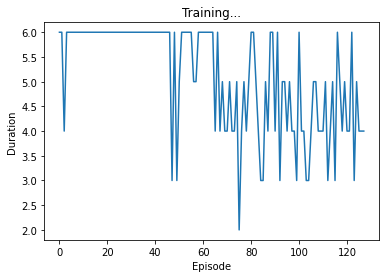

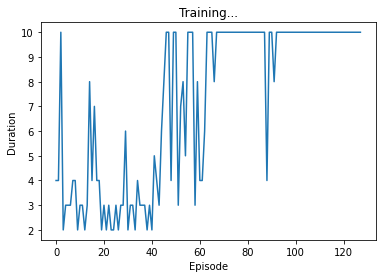

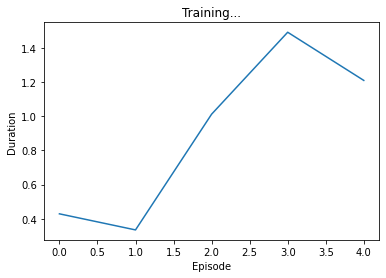

In [21]:
plot_values(episode_durations)
plot_values(episode_rewards)
plot_values(losses)
#plt.ioff()
plt.show()